In [140]:
import pandas as pd 
import numpy as np 
from sklearn import decomposition
from sklearn import preprocessing
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from matplotlib.collections import LineCollection

# Creation de la base de donnée.

In [179]:
#ratings=pd.read_table('/Users/zal/Desktop/ml-1m/ratings.dat',sep="::",engine='python',names=['UserID','MovieID','Rating','Timestamp'])
#users=pd.read_table('/Users/zal/Desktop/ml-1m/users.dat',sep="::",engine='python',names=['UserID','Gender','Age','Occupation','Zip-code'])
#movies=pd.read_table('/Users/zal/Desktop/ml-1m/movies.dat',sep="::",engine='python',names=['MovieID','Title','Genres'])
#links=pd.read_csv('/Users/zal/Desktop/ml-25m/links.csv')
ratings=pd.read_table('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/ml-1m/ratings.dat',sep="::",engine='python',names=['UserID','MovieID','Rating','Timestamp'])
users=pd.read_table('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/ml-1m/users.dat',sep="::",engine='python',names=['UserID','Gender','Age','Occupation','Zip-code'])
movies=pd.read_table('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/ml-1m/movies.dat',sep="::",engine='python',names=['MovieID','Title','Genres'])
links=pd.read_csv('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/ml-25m/links.csv')

On va étudier chaque dataframe.

In [142]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


links donne les identifiants des films dans la base de données d'IMDb.  

In [143]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
movieId    62423 non-null int64
imdbId     62423 non-null int64
tmdbId     62316 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [144]:
movies.tail()

,MovieID,Title,Genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


In [145]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
MovieID    3883 non-null int64
Title      3883 non-null object
Genres     3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


On va réaliser une jointure afin d'avoir les identifiants de Movielens et d'IMDb pour chaque film.

In [146]:
print('avant la jointure il y a')
print(movies.shape[0]) 
print('films')
links['MovieID']=links['movieId']
del links['movieId']
#On renomme la colonne pour realiser la jointure. 
movies=movies.merge(links,on='MovieID',how='inner')
print('après la jointure il y a')
print(movies.shape[0]) 
print('films')

avant la jointure il y a
3883
films
après la jointure il y a
3849
films


On va rajouter une colonne rating au dataframe movie, qui donne la note moyenne du film.    
Pour cela on va utiliser les notes fournies par la base de données d'imdb. On a en effet plus de votes disponibles avec cette base de données qu'avec MovieLens.   
Pour accéder aux notes, on va ouvrir la base de données d'IMDb et utiliser la variable imdbId. 

In [177]:
#title_rating = pd.read_csv('/Users/zal/Desktop/IMDB/title.ratings.tsv', sep="\t") #Base de donnée d'IMDb
title_rating = pd.read_csv('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/title.ratings.tsv.tsv', sep="\t") #Base de données d'IMDb

In [148]:
title_rating.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1663
1,tt0000002,6.1,206
2,tt0000003,6.5,1382
3,tt0000004,6.2,123
4,tt0000005,6.2,2170


In [149]:
title_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101502 entries, 0 to 1101501
Data columns (total 3 columns):
tconst           1101502 non-null object
averageRating    1101502 non-null float64
numVotes         1101502 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 25.2+ MB


On doit retirer les 'tt' dans la variable tconst. Les notes des utilisateurs movies sont sur 5, on va donc diviser par 2 la note IMDb. On change ensuite le nom de la variable tconst pour ensuite realiser une jointure sur la table movies.

In [150]:
title_rating['imdbId']=title_rating['tconst'].str[2:]
title_rating['imdbId']=title_rating.imdbId.astype(int)
movies=movies.merge(title_rating,on='imdbId',how='inner')
#On enlève ensuite les colonnes qui ne sont pas utiles
del movies['tmdbId']
del movies['tconst']
movies['rating']=movies['averageRating']/2 #On met la note IMDb sur 5
del movies['averageRating']
del movies['numVotes']
print('après la jointure il y a')
print(movies.shape[0]) 
print('films')

après la jointure il y a
3841
films


Une soixantaine de films a été supprimée de la base de données. On les retire de la base rating.   

In [151]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [152]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
UserID       1000209 non-null int64
MovieID      1000209 non-null int64
Rating       1000209 non-null int64
Timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB


On va enlever les films qui n'ont pas de note dans la base de données ratings, ou qui ont été retirés lors de la jointure précédente.

In [153]:
print('avant la jointure il y a')
print(ratings.shape[0]) 
print('ratings')
index=movies['MovieID'].to_frame()
ratings=ratings.merge(index,on='MovieID',how='inner')
print('après la jointure il y a')
print(ratings.shape[0]) 
print('ratings')

avant la jointure il y a
1000209
ratings
après la jointure il y a
996723
ratings


On a perdu quelques notes, il y avait sans doute des doublons de movies qui ne correspondaient à aucun film.

On va modifier la variable timestamp, pour avoir l'année du rating.

In [154]:
import time
ratings['Timestamp'] = ratings['Timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000
1,2,1193,5,2000
2,12,1193,4,2000
3,15,1193,4,2000
4,17,1193,5,2000


In [155]:
ratings.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996723 entries, 0 to 996722
Data columns (total 4 columns):
UserID       996723 non-null int64
MovieID      996723 non-null int64
Rating       996723 non-null int64
Timestamp    996723 non-null object
dtypes: int64(3), object(1)
memory usage: 38.0+ MB


In [156]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [157]:
users.info() #On regarde le type de chacune des variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
UserID        6040 non-null int64
Gender        6040 non-null object
Age           6040 non-null int64
Occupation    6040 non-null int64
Zip-code      6040 non-null object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


# Recherche de variables explicatives

On va étudier les différentes données, voir s'il y a des variables à normaliser, ...

In [158]:
print('on étudie les notes des utilisateurs')
print('la note minimale est:')
print(ratings['Rating'].min())
print('la note maximale est:')
print(ratings['Rating'].max())
print('la médiane est:')
print(ratings['Rating'].median())
print('la moyenne est:')
print(ratings['Rating'].mean())

on étudie les notes des utilisateurs
la note minimale est:
1
la note maximale est:
5
la médiane est:
4.0
la moyenne est:
3.5813972387513884


On va étudier l'influence du Genre sur la note d'un film. 

In [159]:
if movies['Genres'].isnull().sum()==0:
    print('Tous les films sont au moins dans une catégorie de genre')

Tous les films sont au moins dans une catégorie de genre


On regarde comment les genres pour les films sont distribués. Pour cela on realise un nuage de mots.
On a les catégories suivantes :
	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

On va créer un dataframe df qui donne des dummy variables pour l'appartenance à un genre. On note df ce dataframe

In [160]:
Genre=['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy',
       'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
df=movies['MovieID']
df = df.to_frame()
for i in range(0,len(Genre)):
    df[Genre[i]]=0
    df.loc[movies['Genres'].str.contains(Genre[i]), Genre[i]] = 1
df.head()

,MovieID,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


On va compter le nombre de films pour chaque catégorie.  
On peut ensuite faire un nuage de mots.

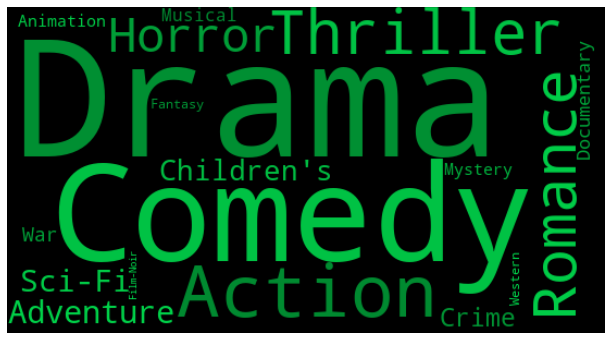

In [161]:
Occurences=[]
H=[]
for i in range (0,len(Genre)):
    H.append(df[Genre[i]].sum())
    Occurences.append([Genre[i],df[Genre[i]].sum()])
    
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = Occurences
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Avec le nuage de mots on voit quels thèmes reviennent le plus parmi les films de la base de données.

On peut representer la même information à l'aide d'un graphique :

<BarContainer object of 18 artists>

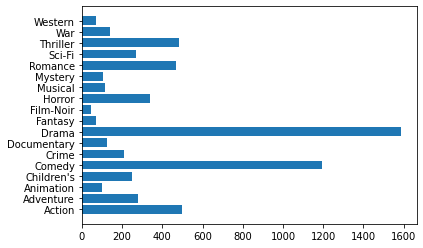

In [162]:
plt.barh(Genre,H)

On étudie ensuite le nombre de genres par film. Dans l'idéal on voudrait que chaque film ne soit que dans une catégorie, pour avoir des variables non corrélées entre elles. On va former des catégories dans ce but, mais aussi par souci de clarté pour les représentation graphiques : on a 18 catégories à représenter ce qui charge beaucoup les graphiques.

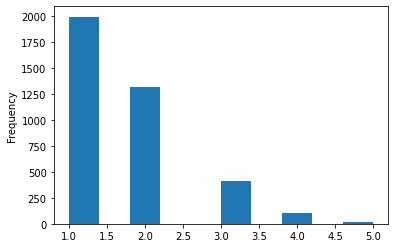

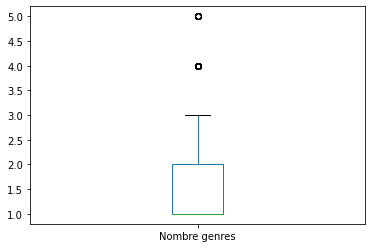

In [163]:
df['Nombre genres']=df['Action']
for i in range(1,len(Genre)):
    df['Nombre genres']+=df[Genre[i]]
df['Nombre genres'].plot.hist()
plt.show()
df['Nombre genres'].plot.box()
plt.show()

On va essayer de regrouper les genres les plus proches entres eux. Pour ce faire on va utiliser la matrice des corrélation entre genres. 
On l'utilise comme matrice de distance, pour ensuite ,avec un algorithme de hierachical clustering ascendant ,determiner quels genres sont les plus similaires.




[132]






In [164]:
def heatmap(df):
    df_new=df.copy()
    del df_new['MovieID'] #On ne veut pas faire de régression sur l'ID du film 
    corr_matrix = df_new.corr()
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        plt.subplots(figsize=(20,14))
        sns.heatmap(corr_matrix, mask=mask, annot=True);

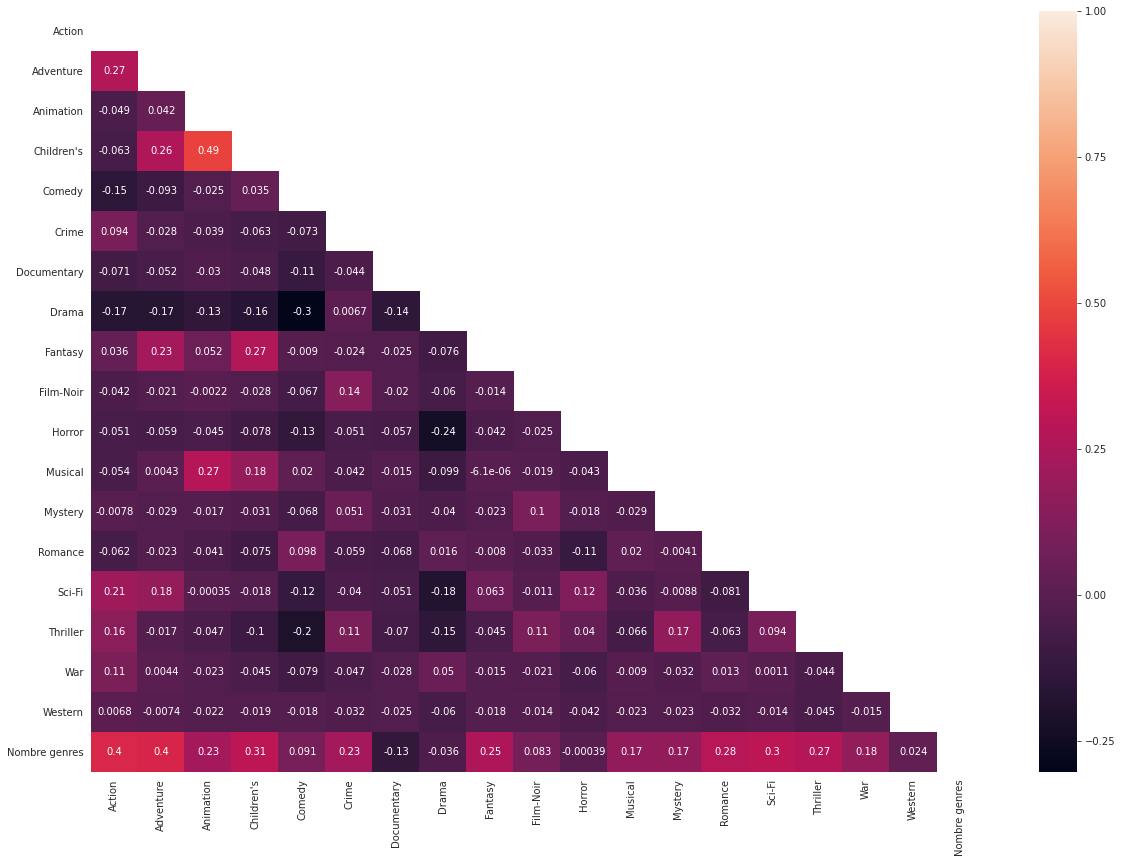

In [165]:
heatmap(df)

Les catégories les plus fortement corrélées sont Animation-Children's (corrélation positive) et Drama-Comedy (corrélation négative)

On veut savoir quels sont les catgéories de films similaires, afin de faire une sélection de variable. Pour cela., on va réalise un dendrogramme, utilisant comme métrique les corrélations entre catégories.

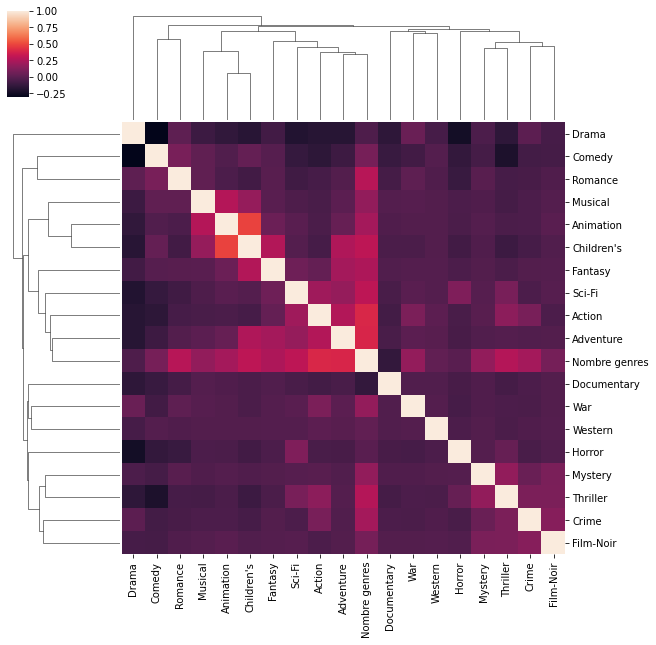

In [166]:
df_new=df.copy()
del df_new['MovieID'] #On ne veut pas faire de régression sur l'ID du film 
corr_matrix = df_new.corr()
sns.clustermap(corr_matrix)

On peut ensuite étudier l'impact de la catégorie sur la note moyenne. On va rassembler certaines catégories trop proche, pour pouvoir réaliser ensuite des régression linéaires.

On rassemble les catégories :
-Documentary,War,Western
-Fantasy, Sci-Fi, Action, Adventure
-Children's, Animation, Musical
-Crime, Film Noir, Thriller, Mystery
-Comedy, Romance
-Drama
-Horror

On va donc créer une nouvelle matrice pour l'appartenance à chaque catgéorie. Pour cela on crée de nouvelles colonnes.

In [167]:
Cluster=['Cluster War','Cluster Action','Cluster Animation','Cluster Thriller','Cluster Comedy','Cluster Drama','Cluster Horror']

In [168]:
df['Cluster War']=df[['War','Western','Documentary']].apply(max,axis=1)
df['Cluster Action']=df[['Action','Adventure','Sci-Fi','Fantasy']].apply(max,axis=1)
df['Cluster Animation']=df[["Children's",'Animation','Musical']].apply(max,axis=1)
df['Cluster Thriller']=df[['Crime','Film-Noir','Thriller','Mystery']].apply(max,axis=1)
df['Cluster Comedy']=df[['Comedy','Romance']].apply(max,axis=1)
df['Cluster Drama']=df['Drama']
df['Cluster Horror']=df['Horror']

On note df_new le dataframe qui ne comporte que la variable MovieID et des dummy variables pour l'appartenance à un cluster.

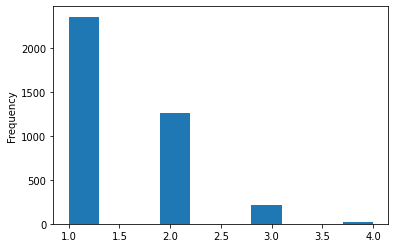

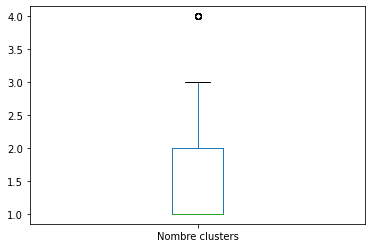

In [169]:
df_new=df.copy()
for i in range (0,len(Genre)):
    del df_new[Genre[i]]
del df_new['Nombre genres']
df_new['Nombre clusters']=df['Cluster War']
for i in range (1,len(Cluster)):
    df_new['Nombre clusters']+=df_new[Cluster[i]]
df_new['Nombre clusters'].plot.hist()
plt.show()
df_new['Nombre clusters'].plot.box()
plt.show()

In [170]:
print('On peut comparer les répartitions statistiques.')
print()
print(df_new['Nombre clusters'].describe())
print()
print(df['Nombre genres'].describe())

On peut comparer les répartitions statistiques.

count    3841.000000
mean        1.450143
std         0.617603
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: Nombre clusters, dtype: float64

count    3841.000000
mean        1.650872
std         0.801824
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: Nombre genres, dtype: float64


In [171]:
df_new.sum()

MovieID              7630562
Cluster War              330
Cluster Action           816
Cluster Animation        341
Cluster Thriller         701
Cluster Comedy          1459
Cluster Drama           1586
Cluster Horror           337
Nombre clusters         5570
dtype: int64

Les "clusters" n'en sont pas vraiment : on a encore beaucoup de films dans plusieurs catégories. On veut voir si ces catégories traduisent tout de même une certaine réalité.
Pour cela on réalise une ACP et on répresente ensuite les différentes catégories dans un plan en deux dimensions.

## Une première ACP

In [172]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

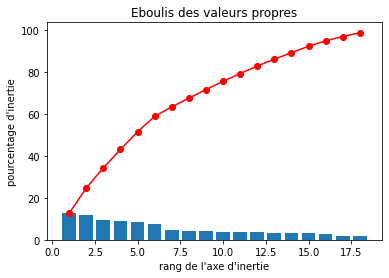

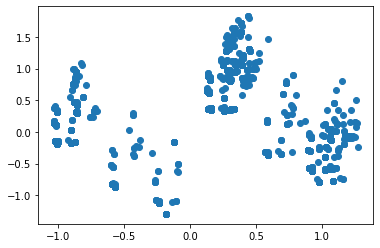

In [173]:
n_comp=18
X=df.copy()
del X['Nombre genres']
del X['MovieID']
std_scale=preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#Calcul composantes pricnipales 
pca=decomposition.PCA(n_comp)
pca.fit(X_scaled)
                
display_scree_plot(pca)
print()
coord=pca.fit_transform(X)
pcs=pca.components_
#display_circles(pcs,n_comp,pca,[(0,1),(2,3),(1,2)])

x=[]
y=[]
z=[]
for i in range(0,len(coord)):
    x.append(coord[i][0])
    y.append(coord[i][1])
    z.append(coord[i][2])
plt.scatter(x,y)

In [174]:
#On crée une liste catégorie qui donne pour chaque point son cluster.
#On va dire que si un film est dans plusieurs clusters, il est tracé en blanc. 
index_color=df_new['Nombre clusters']==1
df_color=df_new[index_color].copy()
df_color['Color']=df_color['Cluster War']
for i in range(1,len(Cluster)):
    df_color['Color']+=df[Cluster[i]]*(i+1)
df_new['color']=0
df_new['color'][index_color]=df_color['Color']
categories=df_new['color'].to_numpy()

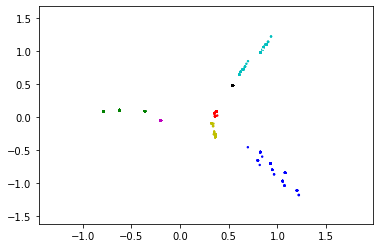

In [175]:
colormap = np.array(['w', 'r', 'b','y','c','g','m','k'])
x=[]
y=[]
z=[]
for i in range (0,len(coord)):
    x.append(coord[i][1])
    y.append(coord[i][2])
plt.scatter(x,y,s=2,c=colormap[categories])

Les points sont très proches dans le plan. On va essayer de tracer les points dans un autre plan : on utilise une base de données fournie par movielens, et on réalise une acp sur l'espace des tags. Dans cet espace on réprésente les films selon leur catégorie.

## Une seconde ACP 

La base de données "genomescores" étant trop volumineuse, on a fait un traitement préalable où on a retiré toutes les données correspondant aux films n'étant pas dans ml-1m et découpé la base en 3 pour réduire son volume.

In [202]:
genomescores1=pd.read_csv('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/genomescores1.csv')
genomescores2=pd.read_csv('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/genomescores2.csv')
genomescores3=pd.read_csv('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/genomescores3.csv')

In [203]:
genomescores=pd.concat([genomescores1,genomescores2,genomescores3],axis=1)

In [204]:
index_movies=genomescores['MovieID'].unique()
index_movies=pd.Series(index_movies)
index_movies=index_movies.to_frame()
index_movies['MovieID']=index_movies[0]
del index_movies[0]
movies_copy=movies.merge(index_movies,on='MovieID',how='inner')


In [205]:
index_movies=movies_copy['MovieID']
index_movies=index_movies.to_frame()
tags=genomescores.merge(index_movies,on='MovieID',how='inner')

In [210]:
score=tags.pivot(index='MovieID',columns='tagId',values='relevance')

In [211]:
n_comp=3

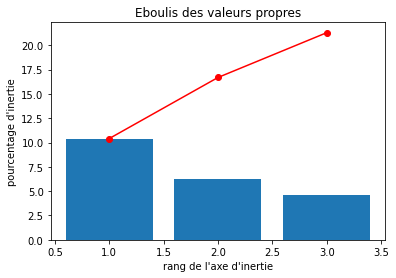

In [212]:
X=score#doit avoir des colones pour ACP 
std_scale=preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#Calcul composantes pricnipales 
pca=decomposition.PCA(n_comp)
pca.fit(X_scaled)
                
display_scree_plot(pca)
coord=pca.fit_transform(X)
pcs=pca.components_
#display_circles(pcs,n_comp,pca,[(0,1),(2,3),(4,5)])

#print(pca.explained_variance_ratio_)
#print(pca.components_)

On veut representer les clusters dans un plan comme précédemment. Pour cela on crée un nouvelle matrice df:

In [214]:
df=df.merge(index_movies,on='MovieID',how='inner')

In [215]:
df_new=df.copy()
for i in range (0,len(Genre)):
    del df_new[Genre[i]]
df_new['Nombre clusters']=df['Cluster War']
for i in range (1,len(Cluster)):
    df_new['Nombre clusters']+=df_new[Cluster[i]]

In [219]:
#On crée une liste catégorie qui donne pour chaque point son cluster.
#On va dire que si un film est dans plusieurs clusters, il est tracé en blanc. 
index_color=df_new['Nombre clusters']==1
df_color=df_new[index_color].copy()
df_color['Color']=df_color['Cluster War']
for i in range(1,len(Cluster)):
    df_color['Color']+=df[Cluster[i]]*(i+1)
df_new['color']=0
df_new['color'][index_color]=df_color['Color']
categories=df_new['color'].to_numpy()

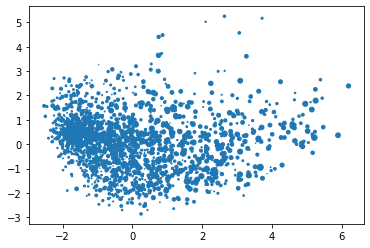

In [224]:
x=[]
y=[]
z=[]
for i in range(0,len(coord)):
    x.append(coord[i][0])
    y.append(coord[i][1])
    z.append(coord[i][2]*10)
plt.scatter(x,y,z)

In [225]:
colormap = np.array(['w', 'r', 'b','y','c','g','m','k'])
x=[]
y=[]
z=[]
for i in range (0,len(coord)):
    x.append(coord[i][0])
    y.append(coord[i][1])
    z.append(coord[i][2])
plt.scatter(x,y,s=2,c=colormap[categories])

ValueError: 'c' argument has 3539 elements, which is inconsistent with 'x' and 'y' with size 3545.